In [1]:
from rake_nltk import Rake
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn.cluster import KMeans,DBSCAN
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def tokenize(text):
    r = Rake()
    r.extract_keywords_from_text(text.lower().replace('nan',' '))
    return r.get_ranked_phrases()[0:10]

### Function to actually recommend similar foods
similarity_thereshold = 0.5
def recommend(name,data,cosine_sim):
    indices = pd.Series(data['name'])
    recommended_items = []
    
    if indices[indices == name].any():
        idx = indices[indices == name].index[0]
        score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
        count = score_series.apply(lambda x : x > similarity_thereshold).sum()
        top_indices = list(score_series.iloc[1 : count+1].index)
        print('Total similar foods count: ', count)

        for i in top_indices:
            recommended_items.append(data.iloc[i]['name'])
        return list(set(recommended_items))
    else:
        print('Oops, Item Not Found :(') 

### Fuction to recommend based on the top order item
def historical_recommend(userid, orders, items, cosine_sim):
    items_order_by_user = orders[orders.userid == userid].name.value_counts()
    top_order_item = items_order_by_user.idxmax()

    item_name = items[items.name == top_order_item].name.values[0]
    item_description = items[items.name == item_name].description.values[0]

    print('Top order food is: ',item_name)
    print('Top order food description is: ',item_description)

    return recommend(item_name,food_items,cosine_sim)    


def match_ingredients(string,ingredients):
    if all(x.lower() in string for x in ingredients):
        return True
    else:
        return False

def ingredient_recommendation(data,ingredients):
    items = data[data['tokens'].apply(lambda x: match_ingredients(x,ingredients))]
    print('Total food item found: {}'.format(items.shape[0]))
    
    for index,row in items.iterrows():
        print('\nitem name: {}\nitem description is: {}'.format(row['name'],row['description']))  

In [2]:
orders = pd.read_csv('../data/full_data.csv',low_memory=False)
orders.head(3)

,OrderId,UserId,RestaurantId,Date,Rating,Comments,Address,Count,ItemId,Price,ViewCount,Name,Description,SearchVector,Type
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,0.0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,0.0,King Crab,NaN,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main


In [3]:
food_items = pd.read_csv('../data/itemsInfo_full.csv',low_memory=False)
food_items.head()

,Id,Price,ViewCount,Name,Description,TagsString,SearchVector,Type
0,8345,0.9,0,Cookie,Freshly baked cookies. One order comes with on...,NaN,'cooki':1,Main
1,8346,7.0,0,12 Cookies,Freshly baked cookies. One order comes with tw...,NaN,'12':1 'cooki':2,Main
2,2046,18.0,0,Sausage Hash-n-eggs,NaN,NaN,'egg':5 'hash':3 'hash-n-egg':2 'n':4 'sausag':1,Main
3,2047,18.0,0,Ham Hash-n-eggs,NaN,NaN,'egg':5 'ham':1 'hash':3 'hash-n-egg':2 'n':4,Main
4,2048,18.0,0,Debakon Hash-n-eggs,DeBakon with hash-n-eggs.,NaN,'debakon':1 'egg':5 'hash':3 'hash-n-egg':2 'n':4,Main


In [4]:
food_items.columns = [c.lower() for c in food_items.columns]
orders.columns = [c.lower() for c in orders.columns]

In [5]:
food_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68100 entries, 0 to 68099
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            68100 non-null  int64  
 1   price         67938 non-null  float64
 2   viewcount     68100 non-null  int64  
 3   name          68082 non-null  object 
 4   description   48742 non-null  object 
 5   tagsstring    34591 non-null  object 
 6   searchvector  68081 non-null  object 
 7   type          68082 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 4.2+ MB


In [6]:
food_items.description.isna().sum()

19358

In [340]:
#items = items[~items.description.isna()].reset_index(drop=True)

In [7]:
food_items.description

0        Freshly baked cookies. One order comes with on...
1        Freshly baked cookies. One order comes with tw...
2                                                      NaN
3                                                      NaN
4                                DeBakon with hash-n-eggs.
                               ...                        
68095                                                  NaN
68096                                                  NaN
68097    White radish, carrot, mini cucumber, Japanese ...
68098                                                  NaN
68099                                                  NaN
Name: description, Length: 68100, dtype: object

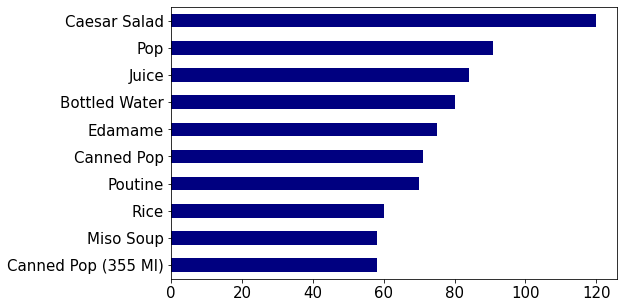

In [8]:
food_items['name'].value_counts()[0:10].plot(kind ='barh', figsize=[8,5], fontsize=15, color='navy').invert_yaxis()


In [343]:
#items = items[~(items.description.duplicated() & items.name)].reset_index(drop=True)

In [9]:
food_items.drop_duplicates(subset = ['name','description'], keep = 'first', inplace = True)
food_items.reset_index(drop=True, inplace=True);

In [10]:
food_items.index

RangeIndex(start=0, stop=49316, step=1)

In [11]:
food_items.columns

Index(['id', 'price', 'viewcount', 'name', 'description', 'tagsstring',
       'searchvector', 'type'],
      dtype='object')

After testing different approaches to get the best result for the simiar foods, we learnt, combining different columns with good information can increase the similarity rate. Therefore we combined the name and description of the food and the results were awesome. Also another reason was, that some resutauarnts did not add a good or at all the descriotion for the foods and we did not want to lose any order.

In [12]:
food_items['bow'] = food_items['name'].map(str) + ',' + food_items['description'].map(str)
food_items['tokenized'] = food_items.bow.apply(tokenize)
food_items['tokens'] = food_items.tokenized.apply(lambda x: ','.join(map(str,x)))

In [13]:
food_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49316 entries, 0 to 49315
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            49316 non-null  int64  
 1   price         49167 non-null  float64
 2   viewcount     49316 non-null  int64  
 3   name          49315 non-null  object 
 4   description   35456 non-null  object 
 5   tagsstring    26058 non-null  object 
 6   searchvector  49314 non-null  object 
 7   type          49315 non-null  object 
 8   bow           49316 non-null  object 
 9   tokenized     49316 non-null  object 
 10  tokens        49316 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.1+ MB


In [14]:
# vectorise the tokens
counter = CountVectorizer()
count_matrix = counter.fit_transform(food_items.tokens)

In [15]:
cosine_sim = cosine_similarity(count_matrix)
print(cosine_sim)

[[1.         0.85280287 0.         ... 0.         0.         0.        ]
 [0.85280287 1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.05634362]
 [0.         0.         0.         ... 0.         0.05634362 1.        ]]


### Sample recommendation based on similar food

In [16]:
sample_item = food_items.iloc[266]
sample_name = sample_item['name']
sample_desc = sample_item['description']
print('The item name is {}\nThe description is:{}'.format(sample_name,sample_desc))

The item name is Whistle Chicken Hot Pot
The description is:nan


In [17]:
recommended_items = recommend(sample_name,food_items,cosine_sim)

Total similar foods count:  20


In [ ]:
for item in recommended_items:
    print("item: ",item)

### Now we will recommend based on the user order history and similarity to the top ordered food

In [ ]:
user_ids = list(set(orders.userid))
sample_userid = orders[orders.userid == random.choice(user_ids)].userid.values[0]
sample_userid

1209

In [ ]:
recommended_items = historical_recommend(sample_userid,orders,food_items,cosine_sim)

Top order food is:  Hammer Hot Chicken
Top order food description is:  This is our Nashville hot chicken, chose your spice level 

Total similar foods count:  19


In [ ]:
for item in recommended_items:
    print("item: ",item)

item:  108. Sizzling Chicken Hot Pot
item:  Hot-and-sour Chicken
item:  Hot Chicken Wings
item:  Whistle Chicken Hot Pot
item:  Nashville Hot Chicken Sliders
item:  87. Hot Spicy Pepper Chicken
item:  882. Spicy Chicken In Hot Pot
item:  Nashville Hot Chicken Burger
item:  Sizzling Chicken Hot Pot
item:  Singing Chicken Hot Pot
item:  Madras Korma Chicken
item:  Chicken
item:  Hot And Spicy Chicken Katsu
item:  Nashville Hot Chicken Sandwich
item:  Chicken Don


This section we just recommend based on selected ingredients

In [ ]:
ingredient1 = 'mushroom'
ingredient2 = 'onion'
ingredient3 = 'rice'
ingredient4 = 'carrots'

ingredients = [ingredient1,ingredient2,ingredient3,ingredient4]
ingredient_recommendation(food_items,ingredients)


Total food item found: 1

item name: Vegetable Fried Rice
item description is: Carrots, corn, onions, mushrooms, and peas with a fried egg.


### Lets explore "Meal Recommendation" with Clustering

In [53]:
orders.head()

AttributeError: 'dict' object has no attribute 'head'

In [ ]:
multiple_items = orders.groupby(['orderid'])['userid'].count()
multiple_items = multiple_items.reset_index()
multiple_items = multiple_items[multiple_items['userid'] > 1].reset_index(drop=True)

list_orders = multiple_items.orderid.values
multiple_items.rename(columns = {'userid':'count'}, inplace = True)

In [ ]:
multiple_items

,orderid,count
0,8,2
1,297,2
2,312,2
3,313,3
4,316,2
...,...,...
6731,14879,3
6732,14880,2
6733,14882,3
6734,14883,2


In [ ]:
multiple_items['orderlist'] = multiple_items.orderid.apply(lambda x: list(orders[orders.orderid == x].name))
multiple_items['unpack-orderlist'] = multiple_items.orderlist.apply(lambda x: ','.join(map(str,x)))
multiple_items['tokenized'] = multiple_items['unpack-orderlist'].apply(tokenize)
multiple_items['tokens'] = multiple_items.tokenized.apply(lambda x: ','.join(map(str,x)))
multiple_items.drop(['tokenized','unpack-orderlist'], axis=1, inplace=True)

In [ ]:
multiple_items.head()

,orderid,count,orderlist,tokens
0,8,2,"[Tableside Spinach Salad, King Crab]","tableside spinach salad,king crab"
1,297,2,"[Kashk Bademjan, Joojeh Kabab With Rice]","kashk bademjan,joojeh kabab,rice"
2,312,2,"[Appetizer Platter, Kashk Bademjan]","kashk bademjan,appetizer platter"
3,313,3,"[Vaziri Kabab With Rice, Joojeh Kabab With Ric...","ghormeh sabzi stew,vaziri kabab,joojeh kabab,r..."
4,316,2,"[Pistachio Baklava, Ghormeh Sabzi Stew With Rice]","ghormeh sabzi stew,pistachio baklava,rice"


In [ ]:
# vectorise the tokens
counter = CountVectorizer()
orders_count_matrix = counter.fit_transform(multiple_items.tokens)


In [ ]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 1000,
        "random_state": 42,}

# making a list of sum of squared errors for different cluster amounts (1-19)
sse = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(orders_count_matrix)
    sse.append(kmeans.inertia_)

In [ ]:
print(sse)

[58066.65276128267, 51982.5026812918, 47682.33491083581, 43686.00472182687, 42123.80161074148, 40588.34992495928, 39212.74929329301, 37780.91094254013, 36968.6196160799, 36199.60543382091, 35494.5584999744, 34414.43113391902, 33102.38083422498, 32519.60390377377, 32248.38355290418, 31903.539138207303, 31385.25018297777, 30907.18356823393, 30439.04566754538, 30396.430835469346, 29896.123636553377, 29904.980372364, 29344.907683800073, 29173.239117183515, 28920.017728713094, 28288.33829306334, 27832.416311309844, 27682.236512339947, 27438.514836451286, 27184.75734643325, 26879.37618400248, 26828.381983570707, 26722.459068263983, 26332.039547399938, 26150.783761484752, 26202.44207764981, 26074.020689804096, 25987.400330662924, 25927.38860553921, 25769.213330085724, 25508.242982785414, 25401.85465051501, 25267.720030314187, 25009.338885338897, 25053.94389677364, 24847.33105320158, 24682.751798488476, 24601.413193995813, 24436.695519124572]


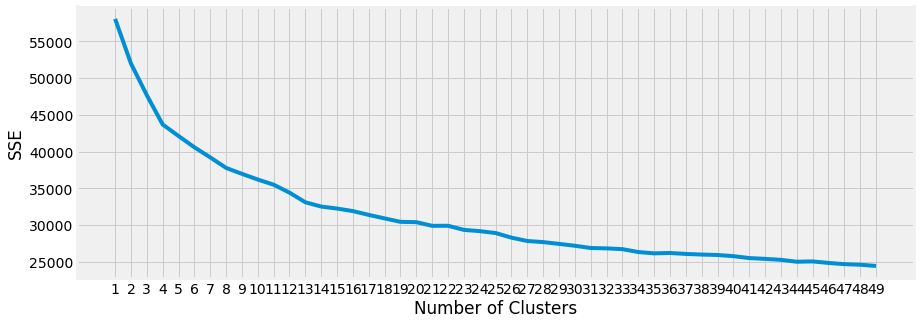

In [ ]:
plt.figure(figsize = (15,5))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 50), sse)
plt.xticks(range(1, 50))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
silhouette_coefficients = []

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(orders_count_matrix)
    score = silhouette_score(orders_count_matrix, kmeans.labels_)
    silhouette_coefficients.append(score)


In [ ]:
max_score = max(silhouette_coefficients)
min_score = min(silhouette_coefficients)
print('max score: ', max_score)
print('min score: ', min_score)

max score:  0.16505468013586172
min score:  0.12741651291928796


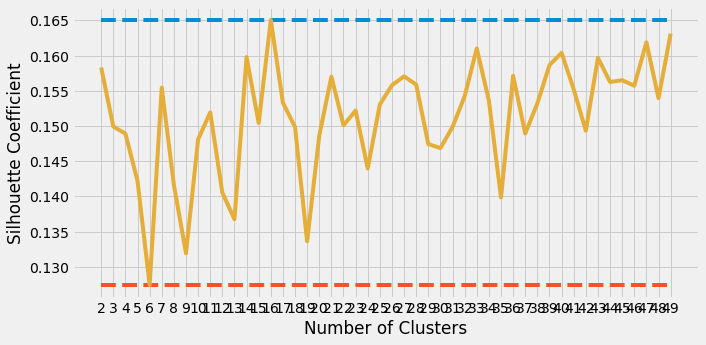

In [ ]:
# plotting the above 
y_max = [max_score] * len(silhouette_coefficients)
y_min = [min_score] * len(silhouette_coefficients)

plt.figure(figsize=(10,5))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 50), y_max,linestyle = 'dashed')
plt.plot(range(2, 50), y_min,linestyle = 'dashed')
plt.plot(range(2, 50),silhouette_coefficients )
plt.xticks(range(2, 50))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

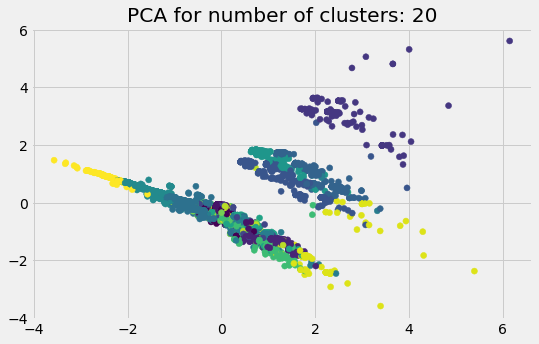

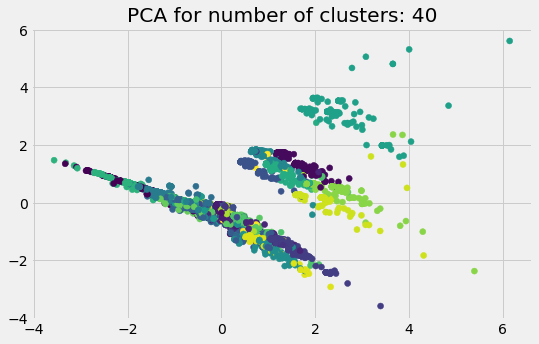

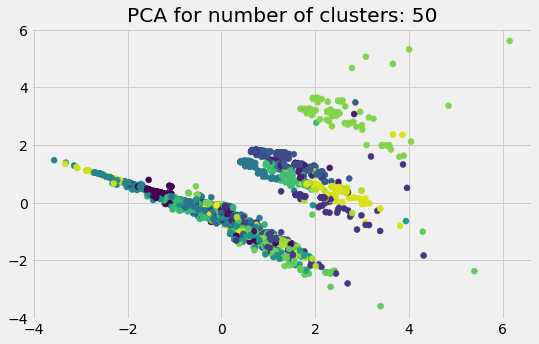

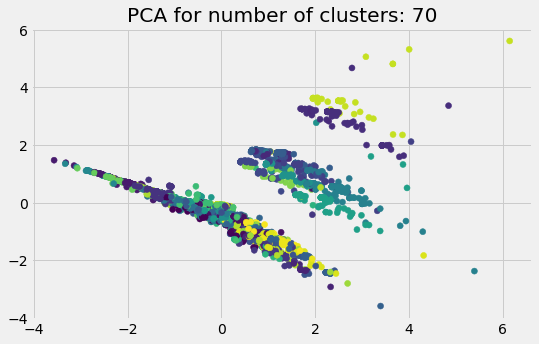

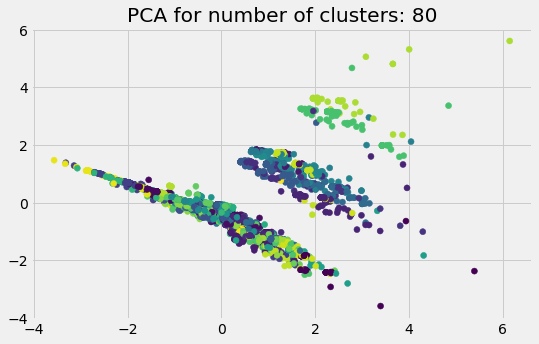

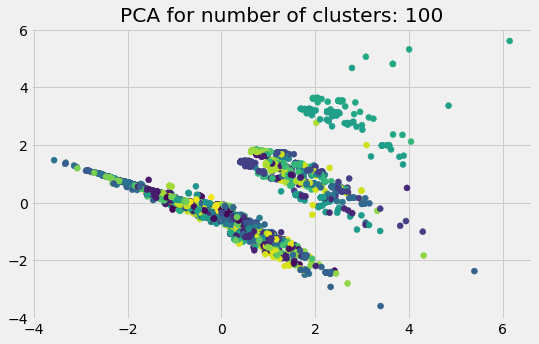

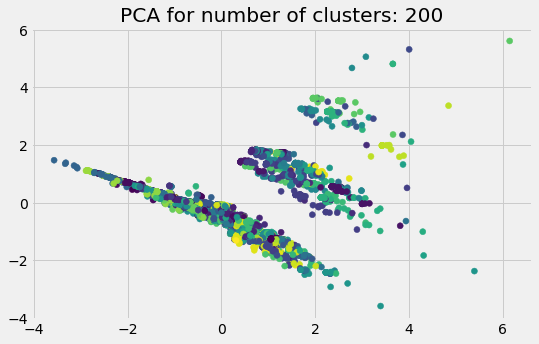

In [ ]:
k_list = [20,40,50,70,80,100,200]

for k in k_list:
    km = KMeans(n_clusters=k)
    cluster_1 = km.fit_predict(orders_count_matrix)

    # Use decomposition.PCA, and pass n_components=2 as parameter
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_title('PCA for number of clusters: ' + str(k))
    pca = PCA(n_components=2)
    pc1, pc2 = zip(*pca.fit_transform(orders_count_matrix.toarray()))
    plt.scatter(pc1, pc2, c=cluster_1.tolist())
    
    plt.show()


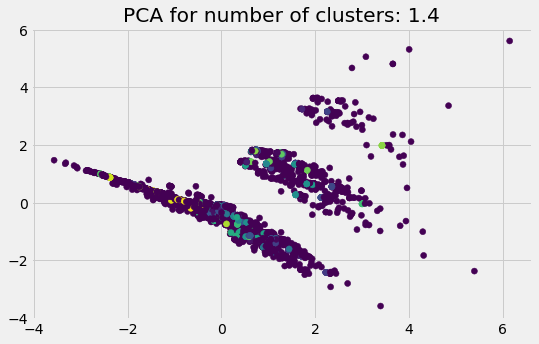

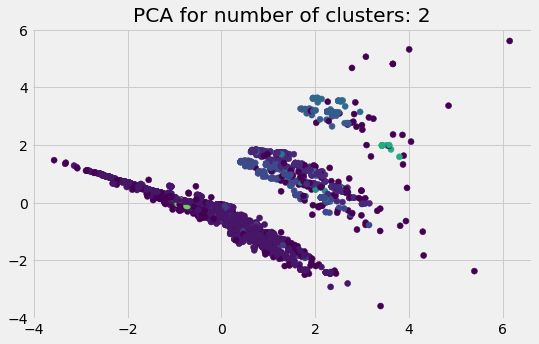

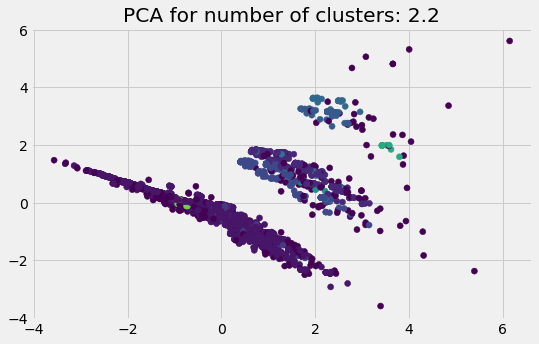

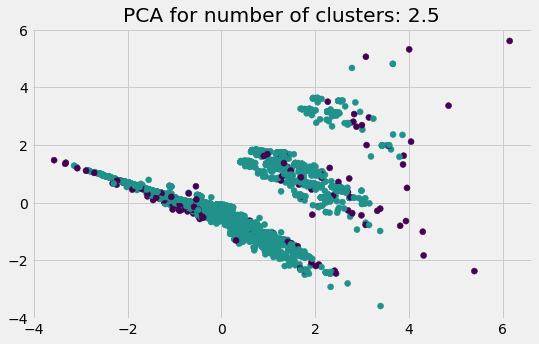

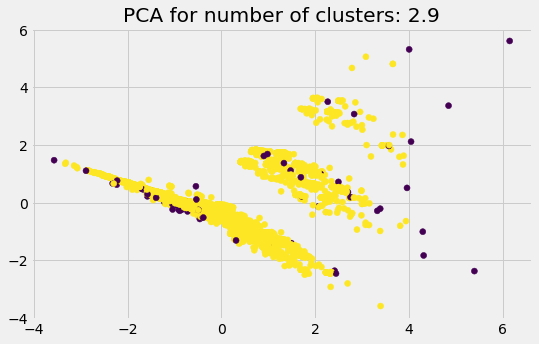

In [ ]:
eps_list = [1.4,2,2.2,2.5,2.9]

for eps in eps_list:
    db = DBSCAN(eps=eps, algorithm='auto')
    cluster_2 = db.fit_predict(orders_count_matrix) 

    # Use decomposition.PCA, and pass n_components=2 as parameter
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_title('PCA for number of clusters: ' + str(eps))
    pca = PCA(n_components=2)
    pc1, pc2 = zip(*pca.fit_transform(orders_count_matrix.toarray()))
    plt.scatter(pc1, pc2, c=cluster_2.tolist())
    
    plt.show()

In [ ]:
#comparing silhouette scores for 2 algos

# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=200)
dbscan = DBSCAN(eps=2.2)

# Fit the algorithms to the features
kmeans.fit(orders_count_matrix)
dbscan.fit(orders_count_matrix)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(orders_count_matrix, kmeans.labels_).round(2)
dbscan_silhouette = silhouette_score(orders_count_matrix, dbscan.labels_).round (2)

# comapring the KMeans and DBscan silhouette scores
kmeans_silhouette, dbscan_silhouette

(0.23, -0.01)

In [ ]:
kmeans = KMeans(n_clusters=200)
multiple_items['cluster'] = kmeans.fit_predict(orders_count_matrix)

In [ ]:
multiple_items.cluster.value_counts()

26     205
46     183
111    133
77     111
71     100
      ... 
192      3
79       2
0        2
116      1
173      1
Name: cluster, Length: 200, dtype: int64

In [ ]:
multiple_items.head()

,orderid,count,orderlist,tokens,cluster
0,8,2,"[Tableside Spinach Salad, King Crab]","tableside spinach salad,king crab",90
1,297,2,"[Kashk Bademjan, Joojeh Kabab With Rice]","kashk bademjan,joojeh kabab,rice",5
2,312,2,"[Appetizer Platter, Kashk Bademjan]","kashk bademjan,appetizer platter",145
3,313,3,"[Vaziri Kabab With Rice, Joojeh Kabab With Ric...","ghormeh sabzi stew,vaziri kabab,joojeh kabab,r...",114
4,316,2,"[Pistachio Baklava, Ghormeh Sabzi Stew With Rice]","ghormeh sabzi stew,pistachio baklava,rice",21
